In [1]:
import jax

import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from dcegm.pre_processing.setup_model import setup_model
from dcegm.solve import (
    get_solve_func_for_model,
)


from toy_models.load_example_model import load_example_models

# set the jax_enable_x64 configuration option
jax.config.update("jax_enable_x64", True)

In [2]:
# model: retirement model without taste shocks and income uncertainty

params = {
    "beta": 0.98,  # discount factor
    "delta": 1.00,  # disutility of work
    "constant": np.log(20.0),  # age-independent labor income
    "rho": 1.00,  # coefficient of relative risk aversion
    "exp": 0.00,  # return to experience
    "exp_squared": 0.0,  # return to experience squared
    "sigma": 0.0,  # shock on labor income sigma parameter/standard deviation
    "lambda": 0.10,  # taste shock (scale) parameter
    "interest_rate": 0.00,  # interest rate on capital
    "max_wealth": 150,  # maximum level of wealth
    "consumption_floor": 0.5,  # consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
}

model_specs = {
    "n_periods": 44,  # number of periods
    "min_age": 20,  # minimum age
    "max_wealth": 150,  # maximum level of wealth
    "n_discrete_choices": 2,  # number of discrete choices
    "n_grid_points": 1500,  # number of grid points
    "quadrature_points_stochastic": 75,  # number of quadrature points for stochastic integration
}

In [3]:
options = {}
options["model_params"] = model_specs
options["model_params"]["n_choices"] = model_specs["n_discrete_choices"]
options["state_space"] = {
    "n_periods": model_specs["n_periods"],
    "choices": [i for i in range(model_specs["n_discrete_choices"])],
    "continuous_states": {
        "wealth": jnp.linspace(
            0,
            options["model_params"]["max_wealth"],
            options["model_params"]["n_grid_points"],
        )
    },
}

model_funcs = load_example_models("dcegm_paper")

model = setup_model(
    options=options,
    state_space_functions=model_funcs["state_space_functions"],
    utility_functions=model_funcs["utility_functions"],
    utility_functions_final_period=model_funcs["final_period_utility_functions"],
    budget_constraint=model_funcs["budget_constraint"],
)

# the solve func will solve the model for a given dictionary of parameters
solve_func = get_solve_func_for_model(model)

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.





Sorted by wealth

wealth: 20.40816, consumption: 20.41
wealth: 20.61034, consumption: 20.51
wealth: 20.81251, consumption: 20.61
wealth: 21.01469, consumption: 20.71
wealth: 21.21687, consumption: 20.82
wealth: 21.37249, consumption: 20.87
wealth: 21.52413, consumption: 20.92
wealth: 21.67576, consumption: 20.98
wealth: 21.82740, consumption: 21.03
wealth: 21.97904, consumption: 21.08
wealth: 22.13067, consumption: 21.13
wealth: 22.27860, consumption: 21.18
wealth: 22.42591, consumption: 21.23
wealth: 22.55045, consumption: 21.25
wealth: 22.67492, consumption: 21.27
wealth: 22.79935, consumption: 21.30
wealth: 22.92376, consumption: 21.32
wealth: 23.04816, consumption: 21.35
wealth: 23.17249, consumption: 21.37
wealth: 23.29679, consumption: 21.40
wealth: 23.42107, consumption: 21.42
wealth: 23.54533, consumption: 21.44
wealth: 23.66952, consumption: 21.47
wealth: 23.79277, consumption: 21.49
wealth: 23.91457, consumption: 21.51
wealth: 24.03452, consumption: 21.53
wealth: 24.15112, 

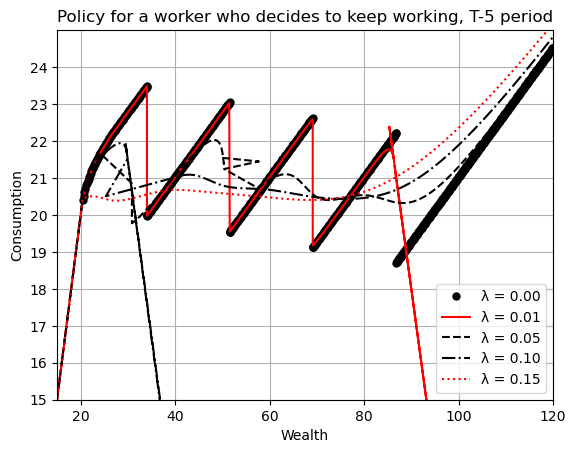

In [4]:
line_styles = [
    {
        "color": "black",
        "marker": "o",
        "linestyle": "None",
        "markersize": 5,
    },  # Scatter black dots
    {"color": "red", "linestyle": "-"},  # Red solid line
    {"color": "black", "linestyle": "--"},  # Black dashed line
    {"color": "black", "linestyle": "-."},  # Black dash-dot line
    {"color": "red", "linestyle": ":"},  # Red dotted line
]

for idx, taste_shock_scale in enumerate([2.2204e-16, 0.01, 0.05, 0.10, 0.15]):
    # Set the taste shock scale and solve the model
    params["lambda"] = taste_shock_scale
    value, policy, endog_grid = solve_func(params)

    # Look at the consumption policy for T-5 period, for a worker who decides to keep working (choice=0)
    test_period = (
        options["state_space"]["n_periods"] - 6
    )  # T-5 period since we are 0-indexed
    state_choice_dict = {
        "period": test_period,
        "lagged_choice": 0,
        "dummy_exog": 0,
        "choice": 0,
    }

    # Plot solution containers directly:
    map_state_choice_to_index = model["model_structure"][
        "map_state_choice_to_index_with_proxy"
    ]
    discrete_states_names = model["model_structure"]["discrete_states_names"]
    state_choice_tuple = tuple(
        state_choice_dict[st] for st in discrete_states_names + ["choice"]
    )
    state_choice_index = map_state_choice_to_index[state_choice_tuple]
    wealth_grid = jnp.take(endog_grid, state_choice_index, axis=0)
    consumption = jnp.take(policy, state_choice_index, axis=0)

    # # Solution with interpolation
    # # Set wealth grid for plotting"""  """
    # wealth_grid = np.linspace(0, 150, 100)
    # # Compute consumption policy for the wealth grid
    # consumption = np.zeros_like(wealth_grid, dtype=float)
    # for var_id, wealth in enumerate(wealth_grid):
    #     policy_interp = policy_for_state_choice_vec(
    #         endog_grid_solved=endog_grid,
    #         policy_solved=policy,
    #         model=model,
    #         state_choice_vec=state_choice_dict,
    #         wealth=wealth,
    #     )
    #     consumption[var_id] = policy_interp
    if idx == 3:
        # print(f"taste_shock_scale: {taste_shock_scale}")
        # for wealth, cons in zip(wealth_grid, consumption):
        #     if wealth >= 20 and wealth <= 40:
        #         print(f"wealth: {wealth:.5f}, consumption: {cons:.2f}")

        print("\n\n" + "Sorted by wealth" + "\n")
        wealth_consumption = list(zip(wealth_grid, consumption))
        wealth_consumption.sort(key=lambda x: x[0])
        for wealth, cons in wealth_consumption:
            if wealth >= 20 and wealth <= 45:
                print(f"wealth: {wealth:.5f}, consumption: {cons:.2f}")

    # Apply specified line styles
    plt.plot(
        wealth_grid,
        consumption,
        # Label with two floating points
        label=f"λ = {taste_shock_scale:.2f}",
        **line_styles[idx],
    )

plt.legend()
plt.title("Policy for a worker who decides to keep working, T-5 period")
plt.ylabel("Consumption")
plt.xlabel("Wealth")
# Set xlim 18 to 120
plt.xlim([15, 120])
plt.ylim([15, 25])
# Set all numbers on yticks
plt.yticks(np.arange(15, 25, 1))
# Set grid
plt.grid()
plt.show()